In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from dataloader import get_evaluation_datasets_by_client  # Assuming this function gets local client datasets
from model import Net
from collections import OrderedDict
from config import NUM_CLASSES, NUM_CLIENTS, GLOBAL_MODEL_PATH, BATCH_SIZE, NUM_FEATURES
from torch.utils.data import DataLoader
from utils import to_tensor
import pandas as pd
import pickle
import time

/home/sharedrive/PythonCodes/.venv311_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
STRATEGY = "FedProx"

## 1. Helper Functions

In [3]:
# Load the global model from the saved path
def load_model(model_path=GLOBAL_MODEL_PATH, input_size=NUM_FEATURES, num_classes=NUM_CLASSES):
    model = Net(input_size=input_size, num_classes=num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [4]:
# Run inference on a client's dataset
def run_inference(model, dataloader, device):
    all_preds = []
    all_labels = []

    # Get the total number of samples from the DataLoader
    total_samples = len(dataloader.dataset)
    # Start the timer before the loop
    start_time = time.time()
    
    with torch.no_grad():
        for batch in dataloader:
            features, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(features)
            _, preds = torch.max(outputs.data, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # End the timer after the loop
    end_time = time.time()    
    # Calculate the total inference time
    total_inference_time = end_time - start_time    
    # Calculate average inference time per sample
    #inference_time_per_sample =  total_inference_time * 1000
    inference_time_per_sample =  total_inference_time * 1000000 / total_samples
    
    return np.array(all_preds), np.array(all_labels), f'{inference_time_per_sample:.4f} us'

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes, title, ax):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, ax=ax)  # Pass ax here directly
    ax.set_title(title)  # Optional: Set a title for each subplot


## 2. Performance/History of Global Model

In [6]:
result_sources = {
    'components': range(12, 20),
    'folds': [1, 2, 3, 4, 5],
    #'folds': [1, 2],
    'marker': ['o', '-', '^' 'x', '-o-'],
    'clients': [1, 2, 3, 4],
    'path': './results/original_{0}_fold_{1}'
}


In [7]:
## This will read pickle file and return the metrics
def parse_history(history_path):
    with open(history_path, 'rb') as file:
        history = pickle.load(file)
        # Extract distributed and centralized losses
        loss_distributed = [loss for _, loss in history.losses_distributed]
        loss_centralized = [loss for _, loss in history.losses_centralized]
        
        # Extract accuracy for distributed and centralized evaluation
        accuracy_distributed = [acc for _, acc in history.metrics_distributed['accuracy']]
        accuracy_centralized = [acc for _, acc in history.metrics_centralized['accuracy']]

        return loss_distributed, loss_centralized, accuracy_distributed, accuracy_centralized
    

In [8]:
##Parse the Training Time
def parse_training_time(time_path):
    # Open the text file and read the value
    with open(time_path, 'r') as file:
    # Read the content of the file and strip any extra spaces or newlines
        content = file.read().strip()
    # Convert the content to a float, round it, and cast it to an integer
    rounded_value = round(float(content))
    return int(rounded_value)


In [9]:
def plot_metrics(y_true, y_pred, classes, title, ax):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, ax=ax)  # Pass ax here directly
    ax.set_title(title)  # Optional

### 2.1 Accuracy/Loss vs Round

2025-02-17 01:57:58,617	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/home/sharedrive/PythonCodes/.venv311_new/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


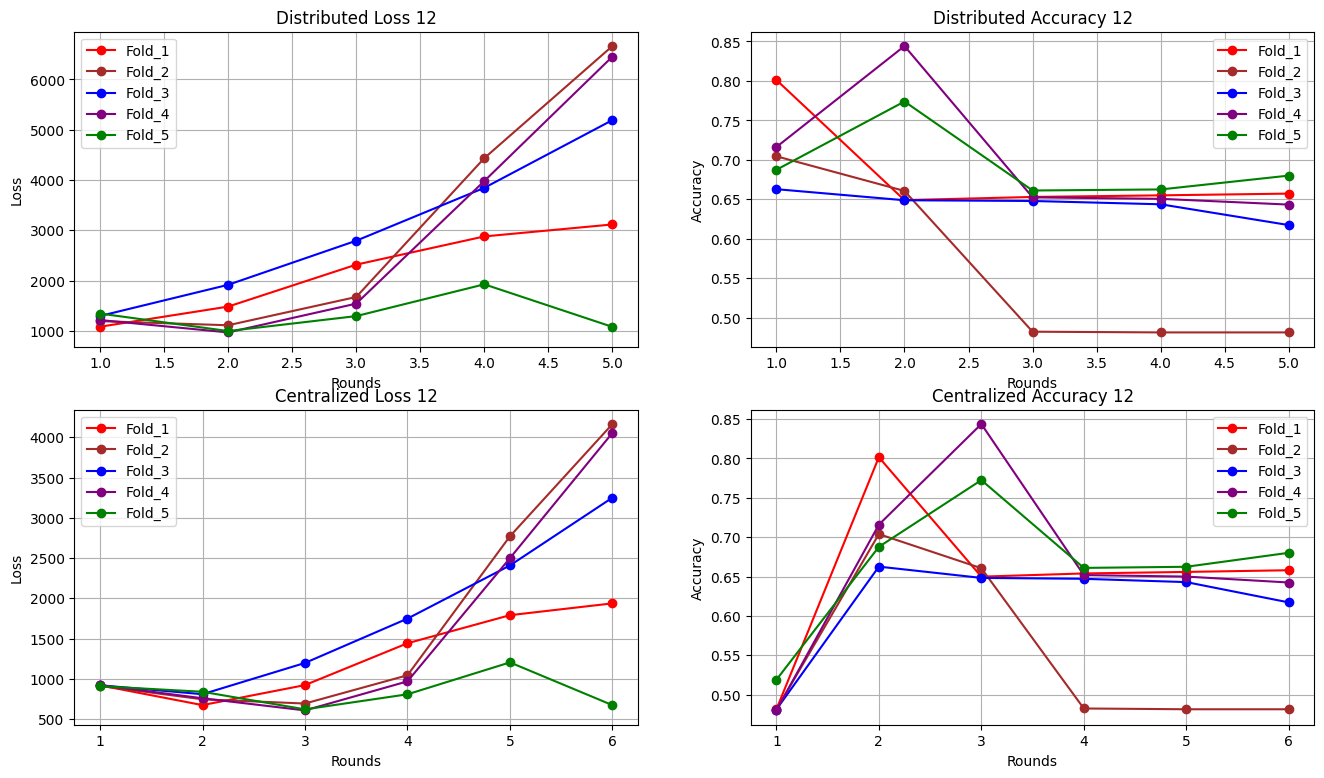

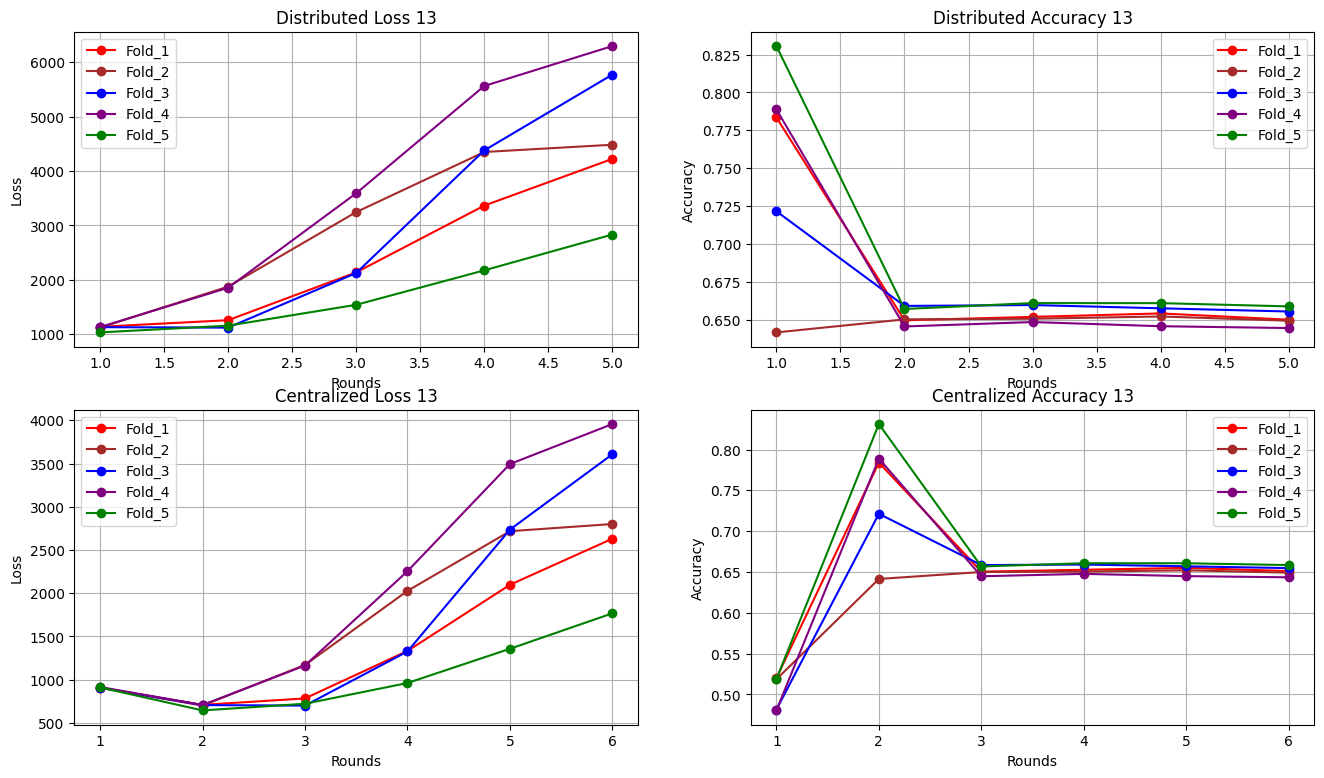

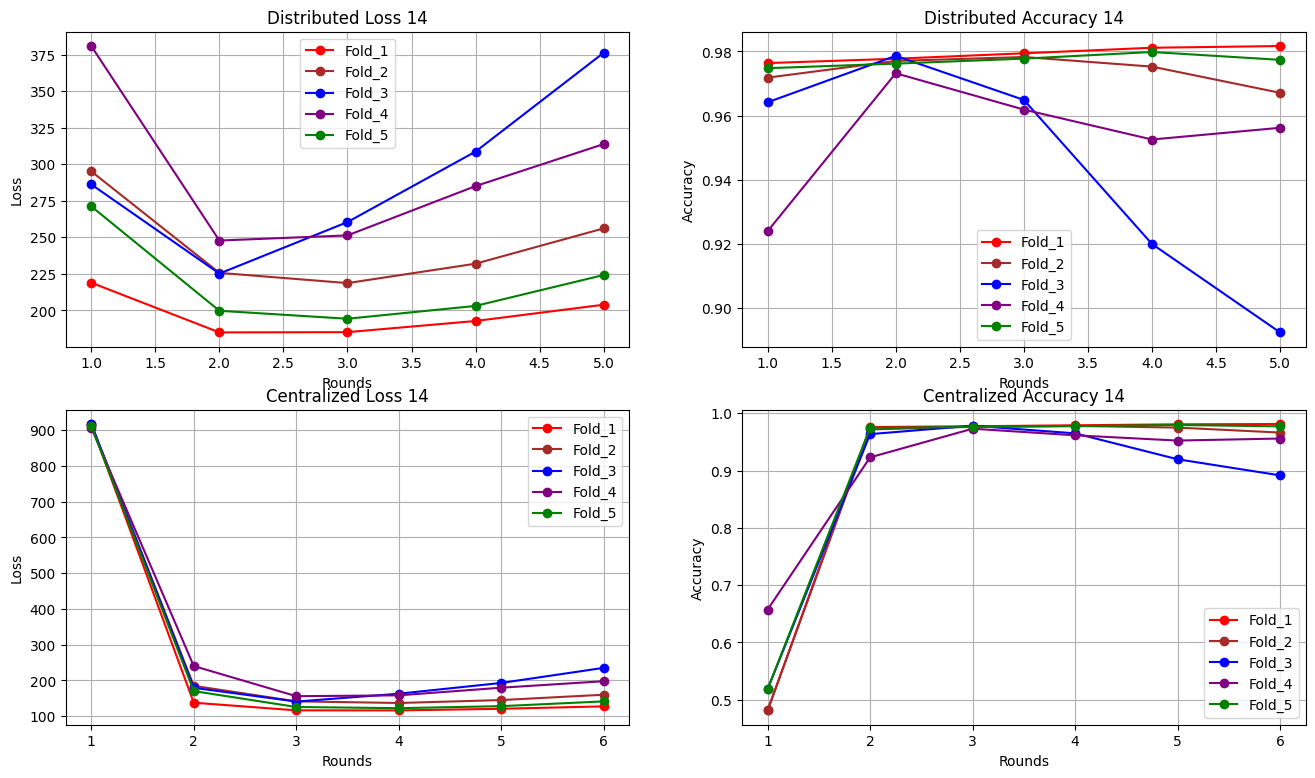

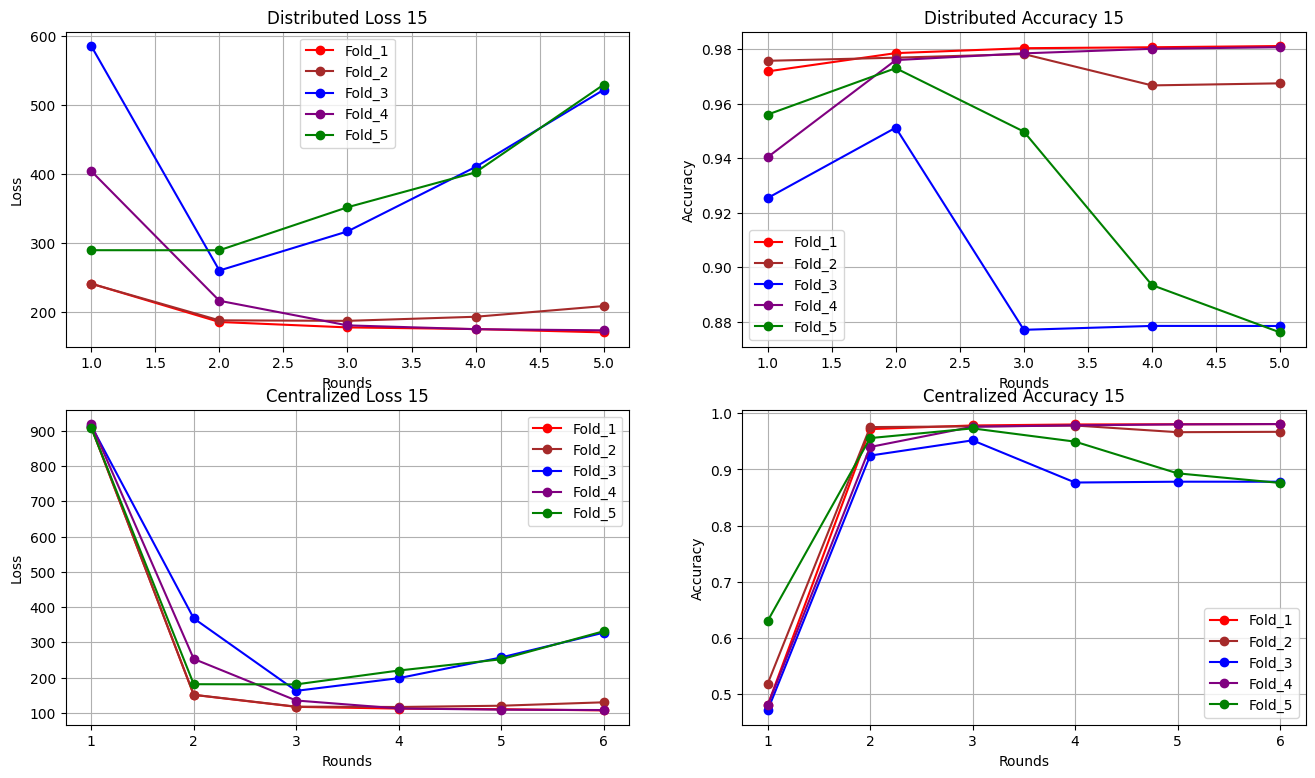

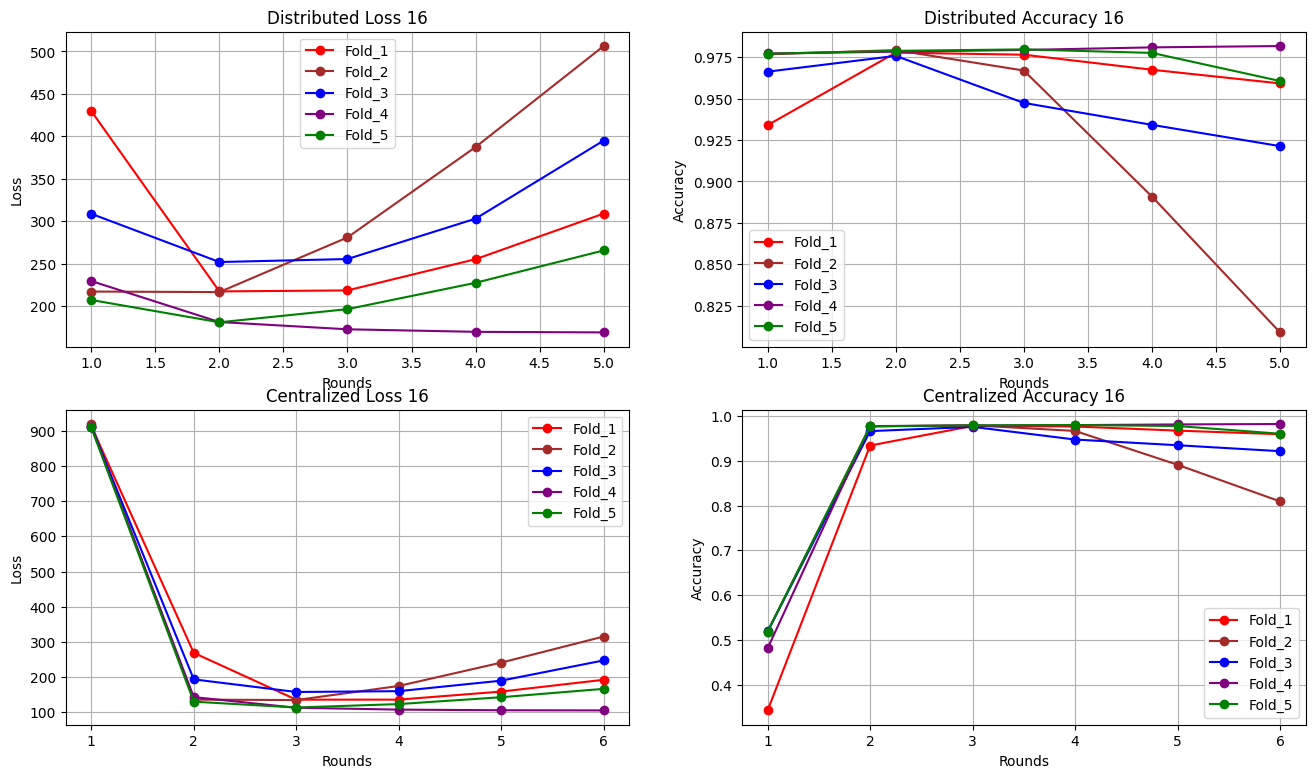

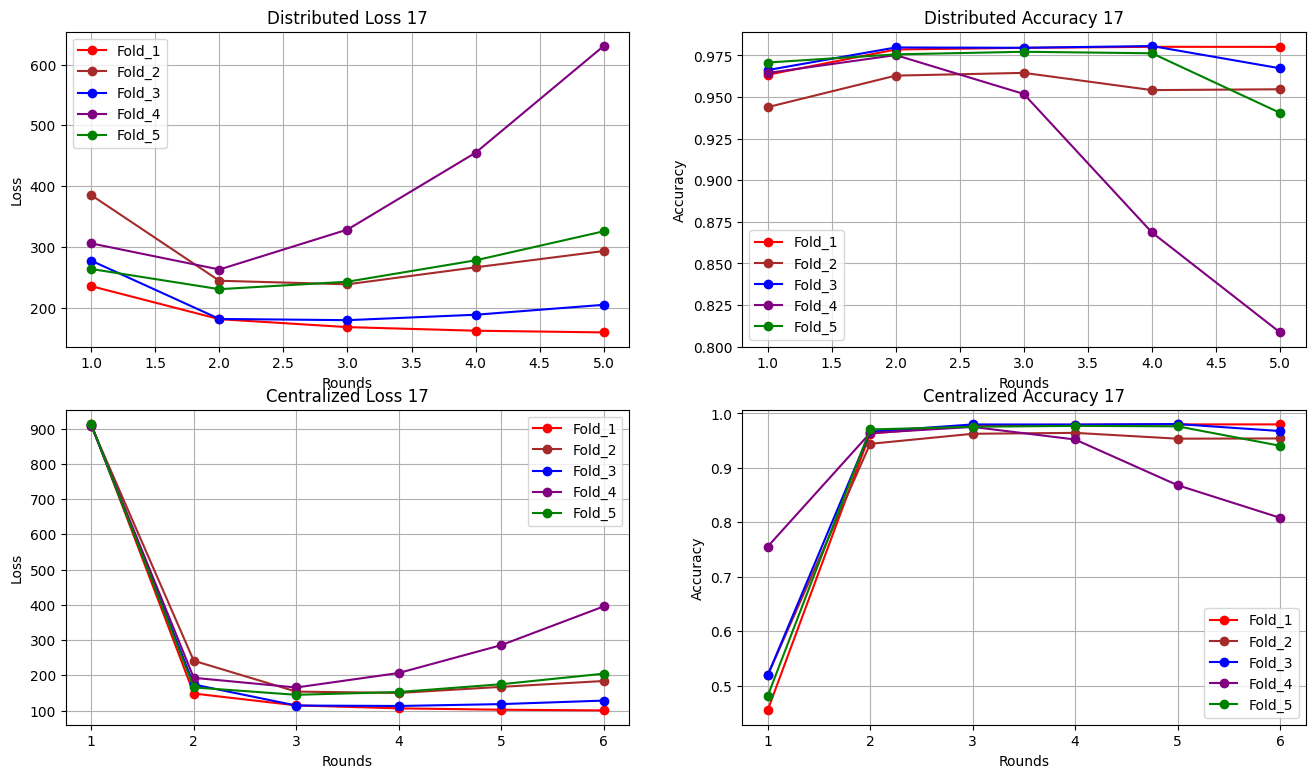

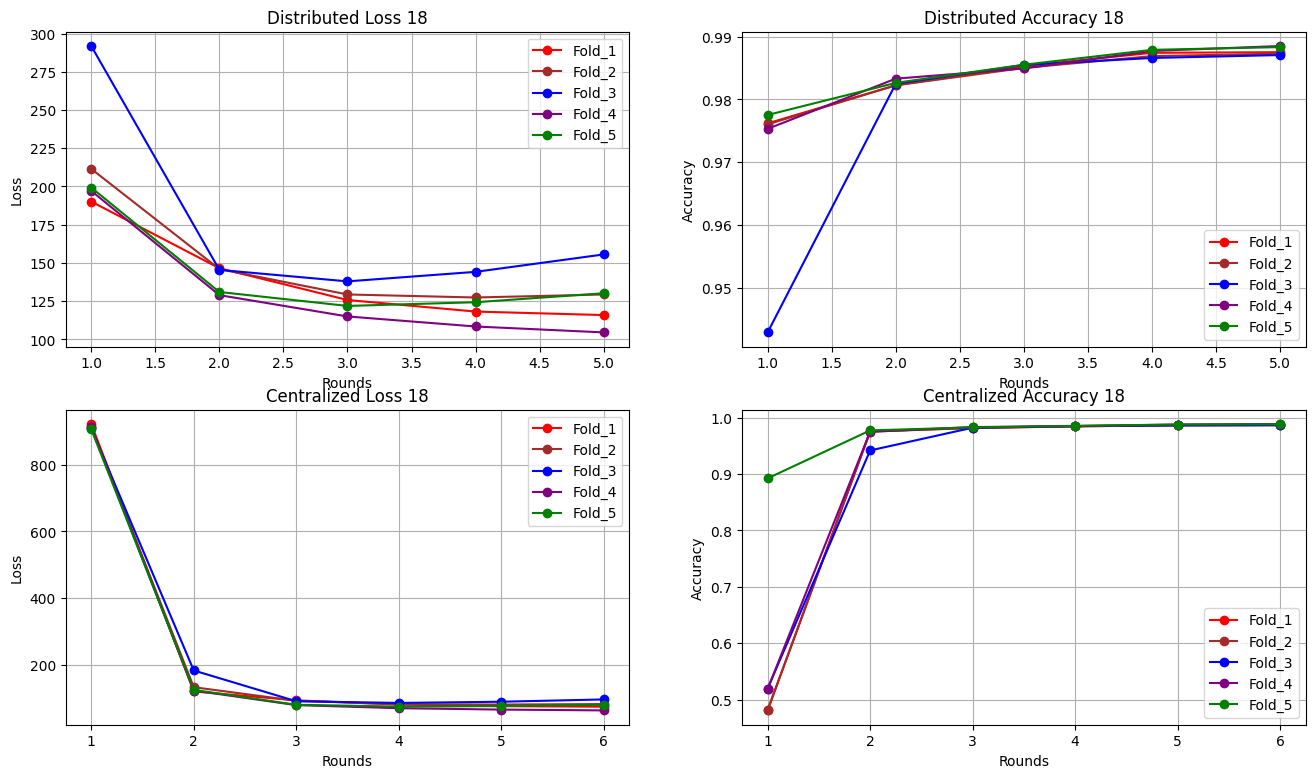

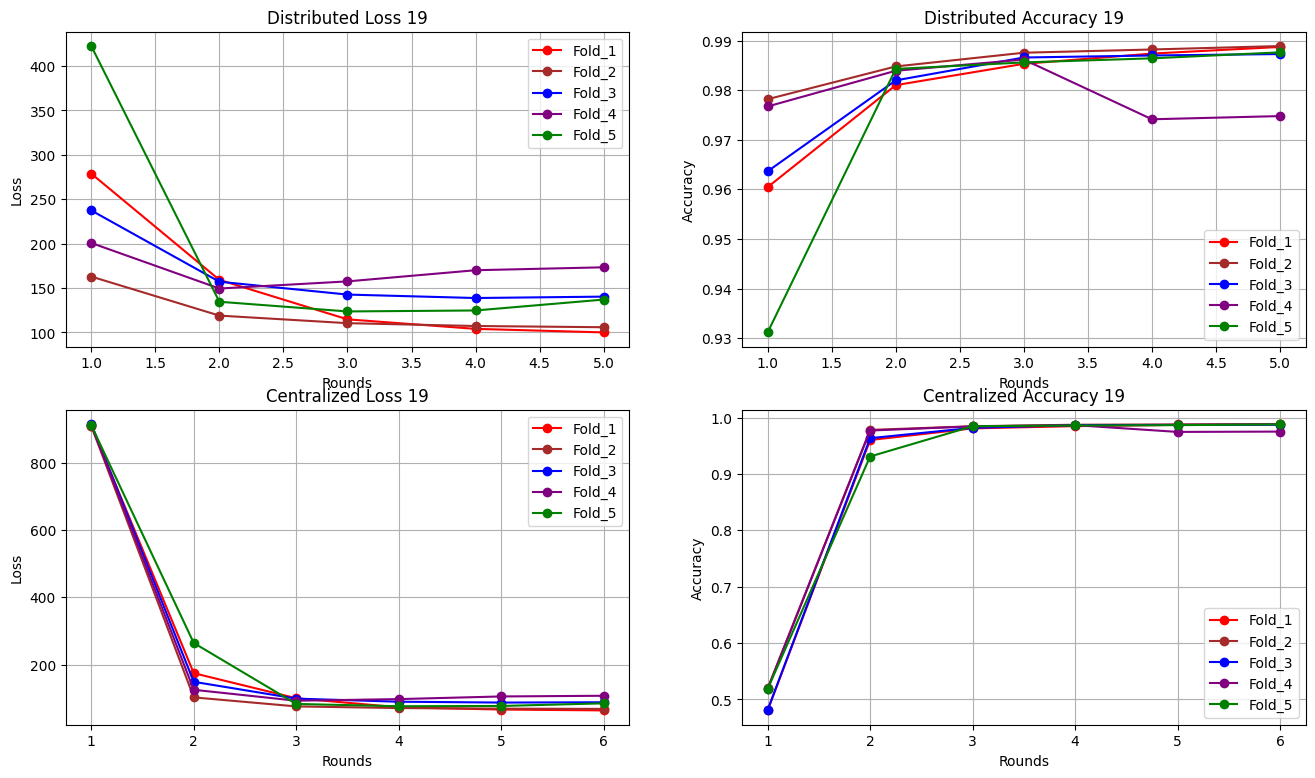

In [10]:
for component in result_sources.get('components'):    
    loss_distributed = [] 
    loss_centralized = [] 
    accuracy_distributed =[] 
    accuracy_centralized = []
   
    for fold in result_sources.get('folds'):
        history_path = result_sources.get('path').format(component, fold) + '/history.pkl'        
        l_d, l_c, a_d, a_c = parse_history(history_path)        
        loss_distributed.append(l_d)
        loss_centralized.append(l_c)
        accuracy_distributed.append(a_d)
        accuracy_centralized.append(a_c)

    history_plots = [
        {
            'type': 'distributed_loss',
            'plot_name': 'Distributed Loss {}',
            'x': 'Rounds',
            'y': 'Loss',
            'plot_position': [0, 0],
            'data': loss_distributed,
            'colors': ['red', 'brown', 'blue', 'purple', 'green']
        },
        {
            'type': 'accuracy_distributed',
            'plot_name': 'Distributed Accuracy {}',
            'x': 'Rounds',
            'y': 'Accuracy',
            'plot_position': [0, 1],
            'data': accuracy_distributed,
            'colors': ['red', 'brown', 'blue', 'purple', 'green']
        },
         {
            'type': 'centralized_loss',
            'plot_name': 'Centralized Loss {}',
            'x': 'Rounds',
            'y': 'Loss',
            'plot_position': [1, 0],
            'data': loss_centralized,
            'colors': ['red', 'brown', 'blue', 'purple', 'green']
        },
        {
            'type': 'centralized_accuracy',
            'plot_name': 'Centralized Accuracy {}',
            'x': 'Rounds',
            'y': 'Accuracy',
            'plot_position': [1, 1],
            'data': accuracy_centralized,
            'colors': ['red', 'brown', 'blue', 'purple', 'green']
        },     
      
    ]

    fig, ax = plt.subplots(2, 2, figsize=(16, 9))  # Adjust the figsize as needed
    for plot in  history_plots:
        position = plot.get('plot_position')
        all_fold_data = plot.get('data')
        #print(len(all_fold_data))
        for i, data in enumerate(all_fold_data):
            rounds = list(range(1, len(data)+1))
            ax[position[0], position[1]].plot(rounds, data, label=f'Fold_{i+1}', marker='o', color=plot.get('colors')[i])
            ax[position[0], position[1]].set_title(plot.get('plot_name').format(component))
            ax[position[0], position[1]].set_xlabel(plot.get('x'))
            ax[position[0], position[1]].set_ylabel(plot.get('y'))
            ax[position[0], position[1]].legend()
            ax[position[0], position[1]].grid(True)
            
            


### 2.2 Training Time

In [11]:
# ##Plotting the Time charts
# for component in result_sources.get('components'):
#     training_time = []
#     for fold in result_sources.get('folds'):
#         ##Parsign the training time
#         training_time_path = result_sources.get('path').format(component, fold) + '/training_time.txt'
#         training_time = parse_training_time(training_time_path)
#         print(f'[Component {component} Fold {fold}]: {training_time} Seconds')

for component in result_sources.get('components'):
    training_time = []
    for fold in result_sources.get('folds'):
        ##Parsign the training time
        training_time_path = result_sources.get('path').format(component, fold) + '/training_time.txt'
        training_time.append(parse_training_time(training_time_path))
        #print(f'[Component {component} Fold {fold}]: {training_time} Seconds')

    training_time_to_string = ", ".join(map(str, training_time))
    print(f'{STRATEGY}, {component}, {training_time_to_string}')
   

FedProx, 12, 980, 965, 952, 955, 1032
FedProx, 13, 1027, 1191, 1129, 1087, 1185
FedProx, 14, 1145, 1115, 1149, 1199, 1118
FedProx, 15, 1169, 1163, 1182, 1155, 1163
FedProx, 16, 1124, 1174, 1154, 1151, 1140
FedProx, 17, 1151, 1076, 1142, 1107, 1156
FedProx, 18, 1127, 1141, 1121, 1120, 1148
FedProx, 19, 1104, 1145, 1112, 1160, 1109


## 3. Accumulate Results
- Accumulate all thre results and save in csv file
- It also stores values reauired for confusion matrix in a varialbe

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
client_metrics = {
    'Strategy': [],
    'Component': [],
    'Fold': [],
    'Client': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1_Score': [],
    'Sample_Number': [],
    'Inference_Time_Per_Sample': []
}

classes = np.arange(NUM_CLASSES)  # Define or import this variable

def accumulate_results(results, confusion_matrix_data):
    components = results.get('components')
    folds = results.get('folds')
    path = results.get('path')
    clients = results.get('clients')
     
    for component in components:  
        for fold in folds:
            global_model = path.format(component, fold) + '/' + 'global_model.pth'
            history = path.format(component, fold) + '/' + 'history.pkl'
            #training_time = path.format(component, fold) + '/' + 'training_time.txt'
            
            model = load_model(model_path=global_model, input_size=component, num_classes=2)
            model.to(device)    
            num_clients = NUM_CLIENTS  # Define or import this variable    
            
            for client in clients:                                
                testset = get_evaluation_datasets_by_client(client, fold=fold, feature_count=component)  
                testloader = DataLoader(to_tensor(testset), batch_size=BATCH_SIZE)
                preds, labels, inference_time_per_sample = run_inference(model, testloader, device)
                client_metrics['Strategy'].append(STRATEGY)
                client_metrics['Component'].append(component)
                client_metrics['Fold'].append(fold)
                client_metrics['Client'].append(client)
                client_metrics['Accuracy'].append(accuracy_score(labels, preds))
                client_metrics['Precision'].append(precision_score(labels, preds))
                client_metrics['Recall'].append(recall_score(labels, preds))
                client_metrics['F1_Score'].append(f1_score(labels, preds))
                client_metrics['Sample_Number'].append(len(labels)),
                client_metrics['Inference_Time_Per_Sample'].append(inference_time_per_sample)

                #Saving info for confusion matrix
                key = f'{component}_{fold}_{client}'
                confusion_matrix_data[key] = {
                    'preds': preds,
                    'labels': labels,
                    'classes': np.arange(NUM_CLASSES)
                }   

    ##Converting into datafram for better visualization
    df = pd.DataFrame(client_metrics)
    print(df.to_string(index=False))
    return df, confusion_matrix_data           
    

In [13]:
confusion_matrix_data = {}
result_df, store_results_df = accumulate_results(result_sources, confusion_matrix_data)

/home/sharedrive/PythonCodes/.venv311_new/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sharedrive/PythonCodes/.venv311_new/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sharedrive/PythonCodes/.venv311_new/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Strategy  Component  Fold  Client  Accuracy  Precision   Recall  F1_Score  Sample_Number Inference_Time_Per_Sample
 FedProx         12     1       1  0.482905   0.000000 0.000000  0.000000          84000                31.8717 us
 FedProx         12     1       2  0.442714   0.000000 0.000000  0.000000          84000                10.0157 us
 FedProx         12     1       3  0.852405   0.786032 0.968429  0.867749          84000                 9.3377 us
 FedProx         12     1       4  0.854060   0.783221 0.979119  0.870282          84000                 9.4370 us
 FedProx         12     2       1  0.482905   0.000000 0.000000  0.000000          84000                11.2764 us
 FedProx         12     2       2  0.442726   0.000000 0.000000  0.000000          84000                 9.3382 us
 FedProx         12     2       3  0.500000   0.000000 0.000000  0.000000          84000                10.0897 us
 FedProx         12     2       4  0.500000   0.000000 0.000000  0.000000       

## 4. Confusion Matrix (per client per Fold)

In [14]:
plots = [
    {
        'client_id': 1,
        'plot_name': 'Client 1',
        'plot_position': [0, 0]
    },
    {
        'client_id': 2,
        'plot_name': 'Client 2',
        'plot_position': [0, 1]
    },
    {
        'client_id': 3,
        'plot_name': 'Client 3',
        'plot_position': [1, 0]
    },
    {
        'client_id': 4,
        'plot_name': 'Client 4',
        'plot_position': [1, 1]
    }   
]

In [15]:

# for component in result_sources.get('components'):
#     for fold in result_sources.get('folds'):
#         #print(f" Plots for Components: {component}, and Folds: {fold}")
#         fig, ax = plt.subplots(2, 2, figsize=(12, 10))  # Adjust the figsize as needed
#         for plot in plots:
#             client = plot.get('client_id')
#             key = f'{component}_{fold}_{client}'
#             data = confusion_matrix_data[key]
#             title = "{0} ({1}_{2})".format(plot['plot_name'], component, fold)
#             plot_confusion_matrix(data['labels'], data['preds'], data['classes'], title, ax = ax[plot['plot_position'][0], plot['plot_position'][1]])
#         plt.tight_layout()
#         plt.show()
#         print("---------------------------------------------------------------------------------------------------------------------------------")
#         print("---------------------------------------------------------------------------------------------------------------------------------")

